# Introduction to Data Science 
# Lecture 8: Hypothesis testing and statistical inference
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecutre, we'll cover 
* Hypothesis testing
* Central limit theorem
* A/B testing

Mandatory reading:
[WIRED article on A/B testing](http://www.wired.com/2012/04/ff_abtesting/)

Mandatory listening:
[Planet Money Episode 669: A or B](https://www.npr.org/sections/money/2015/12/11/459412925/episode-669-a-or-b)

Further reading: Jay L. Devore, Probability and Statistics for Engineering and the Sciences, 9th ed. Cengage Learning (2016) Ch. 8 and 9.

For a more complete treatment, take Math 3070 (Applied Statistics I).


In [1]:
#imports and setup
import pandas as pd

import scipy as sc
from scipy.stats import bernoulli
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import t

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Recap Lecture 4: Descriptive vs. Inferential Statistics 

*Descriptive statistics* quantitatively describes or summarizes features of a dataset. 

*Inferential statistics* attempts to learn about the population from which the data was sampled. 

## Recap Lecture 4:  discrete random variables

*Discrete random variables* take discrete values with preassigned probabilities described by a probaility mass function (PMF). If $X$ is the random variable and $f(k)$ is the PMF, we say "the probability that $X$ takes value $k$ is given by $f(k)$" and write
$$
\textrm{Prob}(X=k) = f(k).
$$

### Bernoulli distribution
A Bernoulli random variable can take the values $k=0$ or $1$ and has PMF
$$
f(k) = \begin{cases} p & k=1 \\ 1-p & k = 0 \end{cases}
$$


Some facts about Bernoulli variables: 
* mean is $p$
* variance is $p(1-p)$

**Example:** The Bernoulli distribution with $p=0.5$ describes a 'fair' coin toss where 1 and 0  represent "heads" and "tails", respectively. If the coin is unfair, then we would have that $p\neq 0.5$.

### Binomial distribution

A binomial r.v. takes values $k=0,1,\ldots,n$, with a probability given by the pmf 
$$
f(k) = \binom{n}{k} p^k (1-p)^{n-k}.
$$
Here, $\binom{n}{k} = \frac{n!}{k!(n-k)!}$ in the binomial coefficient that describes how many ways there are to choose a subset of $k$ elements, disregarding their order, from a set of $n$ elements.
 

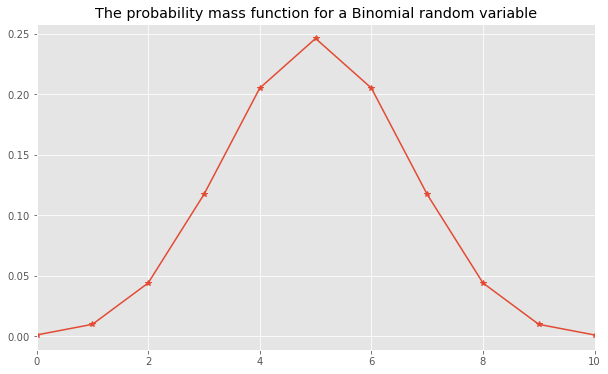

In [2]:
n =10
p = 0.5
f = lambda k: binom.pmf(k, n=n,p=p)

x = sc.arange(n+1);
plt.plot(x, f(x),'*-')
plt.title("The probability mass function for a Binomial random variable")
plt.xlim([0,n])
plt.show()

Some facts about the binomial distribution:
- A binomial random variable is just the sum of $n$ Bernoulli random variables. You can think of it as summarizing the resutls of $n$ coin flips by just keeping track of the total number of heads.
- The mean is  $np$
- The variance is  $np(1−p)$

### Poisson distribution
You also saw the Poisson random variable in the homework, which is another example of a discrete random variable. 


## Recap Lecture 4:  continuous random variables

A *continuous random variable* can take any real value, but some numbers are more likely than others. The probability is given by the *probability density function (PDF)*, which is analogous to the PMF for discrete random variables. If f(x) is the PDF for the random variable $X$, then the probability that $X$ takes the value in the interval $[a,b]$ is given by 

$$
\textrm{Prob}(X\in[a,b]) = 
\int_a^b f(x) dx.
$$
This is just the area under the curve for this interval.

### Example: Normal (Gaussian) distribution 

The *probability density function (PDF)* for a normal (Gaussian) random variable is
$$
f(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }}
e^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} }.
$$
This is sometimes referred to as the 'bell curve'.

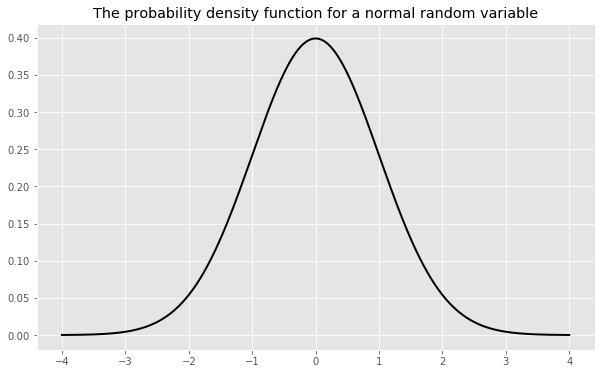

In [3]:
mu = 0 # mean
sigma = 1 # standard deviation 
x = sc.arange(mu-4*sigma,mu+4*sigma,0.001);
pdf = norm.pdf(x,loc=mu, scale=sigma)
plt.title("The probability density function for a normal random variable")
plt.plot(x, pdf, linewidth=2, color='k')
plt.show()

Some facts about the normal distribution:
- The mean is $\mu$
- The variance is  $\sigma^2$

To compute the integral 
$$
\textrm{Prob}(X\in[a,b]) = 
\int_a^b f(x) dx,
$$
it is useful to define the *cumulative distribution function* (CDF)
$$
F(x) = \int_{-\infty}^x f(x) dx.
$$
Then we can write 
$$
\int_a^b f(x) dx =
\int_{-\infty}^b f(x) dx  - \int_{-\infty}^a f(x) dx =
F(b) - F(a).
$$
This is convenient because we know longer have to evaluate an integral! However, there isn't a nice way to write $F(x)$ for the normal distribution in terms of elementary functions. So we just think about $F(x)$ as a known function that we can easily compute using python. 

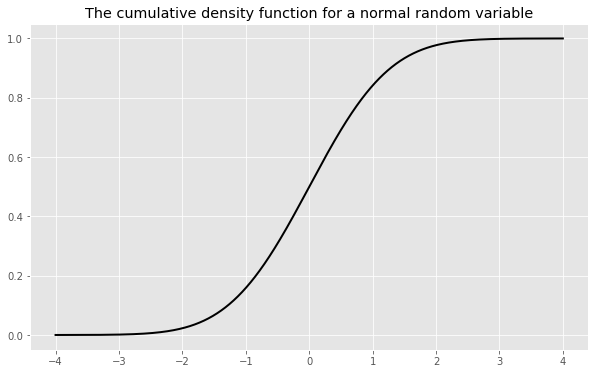

In [4]:
mu = 0 # mean
sigma = 1 # standard deviation 
x = sc.arange(mu-4*sigma,mu+4*sigma,0.001);
cdf = norm.cdf(x,loc=mu, scale=sigma)
plt.title("The cumulative density function for a normal random variable")
plt.plot(x, cdf, linewidth=2, color='k')
plt.show()

### Exercise 
Interpet the following in terms of normal random variables:
- $\int_{-\infty}^1 f(x) dx = F(1)$

In [5]:
norm.cdf(1, loc=mu, scale=sigma)

0.84134474606854293

- $\int_{-1}^1 f(x) dx = F(1) - F(-1)$ 

In [6]:
norm.cdf(1, loc=mu, scale=sigma) - norm.cdf(-1, loc=mu, scale=sigma) 

0.68268949213708585

Note that $\int_{-\infty}^\infty f(x) dx = 1$

In [7]:
norm.cdf(sc.inf, loc=mu, scale=sigma)

1.0


**Remark:** There are many other continous random variables, but in this class we'll only consider normal random variables.

## Hypothesis testing

Suppose we have a coin and we want to determine whether or not it is 'fair'. We could flip it many, many times and count how many heads we obtain. If the fraction of heads is approximately $0.5$, we might argue that the coin is fair. 

This is an example of statistical inference. We are trying to determine something about the coin from samples of coin flips. 

Let's say we flip a coin $n=1000$ times. If the coin is fair, the outcome is described by the Binomial distribution with $p=0.5$. 

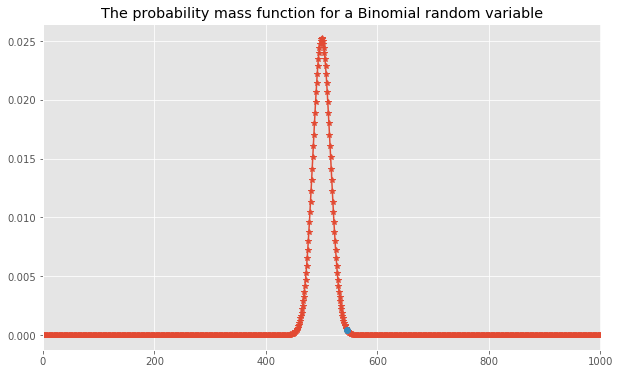

In [8]:
f = lambda k: binom.pmf(k, n=1000,p=0.5)

x = sc.arange(1001);
plt.plot(x, f(x),'*-')
plt.plot(545,f(545),'o')
plt.title("The probability mass function for a Binomial random variable")
plt.xlim([0,1001])
plt.show()

Suppose that in our experiment, we saw $545$ heads. The probability of this occuring is 
f(k = 545):

In [9]:
binom.pmf(545, n=1000,p=0.5)

0.00043885543055769712

In hypothesis testing, the more important question is: what is the probability of seeing a value as extreme or more extreme than the value that we observed? 

I would say that any result $\leq 455$ or $\geq 545$ is 'as or more extreme'. Why?

So the probability of seeing as extreme of an outcome is:

In [10]:
s = sum(binom.pmf(sc.arange(0,456),n=1000,p=0.5)) + sum(binom.pmf(sc.arange(545,1001),n=1000,p=0.5))
print(s)
print(1-s)

0.00486173639188
0.995138263608


So the likelihood of seeing so few heads or tails is just $0.49\%$. So it is very unlikely that if the coin were fair, we would see this result! Maybe so unlikely that we would declare that the coin is unfair? This is the idea behind **hypothesis testing**. 

**Note**: I didn't say that it is unlikely that the coin itself is unfair. Only if it were to be fair, it would be unlikely to see this result. 

In *hypothesis testing*, we make a null hypothesis, written $H_0$. In this case, the null hypothesis is
$$
H_0: \text{the coin is fair, i.e., $p=0.5$}.
$$
The alternative hypothesis, $H_a$, is typically the hypothesis that the researcher wants to validate. In this case, $H_a$ is that the coin is unfair, i.e., $p\neq 0.5$. 

We also choose a *significance level* for the test, $\alpha$, traditionally $1\%$ or $5\%$. 
In this case, let's choose a significance level of $\alpha = 1\%$. 

We then perform an experiment. In this case, we flip the coin 1000 times and count the number of heads (in this case 545). 

Finally, assuming the null hypothesis is true, we compute how how likely it is to see a number that is at least as far from the expected value as the number obtained. In our case, this is $0.49\%$. The is called the *p-value*. Since $p=0.49\%$ is smaller than the chosen significance level, $\alpha = 1\%$, we reject the null hypothesis and declare the coin to be unfair.  

Some comments about the p-value:
1. A p-value is a probability calculated assuming that $H_0$ is true. 
+ The smaller the p-value, the stronger the evidence against $H_0$.
+ **Warning:** A p-value is not the probability that the null hypothesis is true or false. It is the probability that an erroneous conclusion is reached. In this example, it is the probability that the coin actually is fair and we just happened to see an outcome as extreme as 545 heads.

To avoid computing sums (as above) and to 'normalize' the above procedure, it is useful to introduce the *Central Limit Thoerem*. 

## Central Limit Theorem 

One of the reasons that the normal distribution is **so important** is the following theorem. 

**Central Limit Theorem.** Let $\{X_1,\ldots, X_n\}$ be a sample of $n$ random variables chosen identically and independently from a distribution with mean $\mu$ and finite variance $\sigma^2$. If $n$ is 'large', then 
- the sum of the variables $\sum_{i=1}^n X_i$ is also a random variable and is approximately **normally** distributed with mean $n\mu$ and variance $n\sigma^2$ and
- the mean of the variables $\frac{1}{n}\sum_{i=1}^n X_i$ is also a random variable and is approximately **normally** distributed with mean $\mu$ and variance $\frac{\sigma^2}{n}$.

How can we use the central limit theorem (CLT)? 

Recall that a binomial random variable is the sum of $n$ bernoulli random variables. So the CLT tells us that if $n$ is large, binomial random variables will be distributed approximately normally. That is, if we flip a coin many times, the number of heads that we're likely to see is described by a normal distribution. This provides a different (easier) way to answer the question: How unlikely is it to flip a fair coin 1000 times and see 545 heads? 

Suppose we flip a fair ($p=0.5$) coin 1000 times. 

*Question:* How many heads do we expect to see? 

The CLT says that the number of heads (= sum of Bernoulli r.v. = binomial r.v.) is approximately normally distributed with mean 
$$ 
n\mu = np = 1000*0.5 = 500 
$$
and variance 
$$ 
n \sigma^2 = np(1-p) = 1000*0.5*0.5 = 250. 
$$

Let's do an experiment to see how good the CLT is for Bernoulli random variables. We'll call flipping a fair coin n=1,000 times and counting the number of heads a "simulation". Recall that the outcome is precisely a binomial random variable with n=1,000 and p = 0.5. We'll do 10,000 simulations and then compare the histogram of the binomial random variables and the normal distribution predicted by the CLT. 

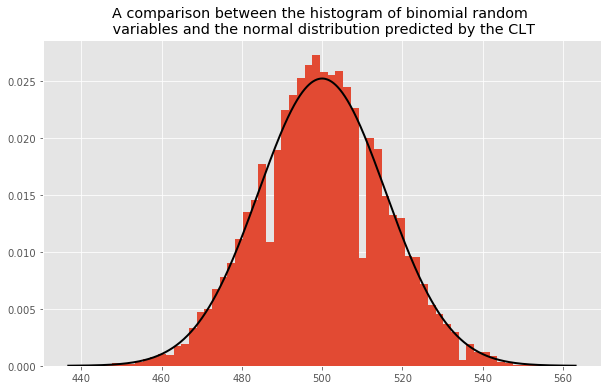

In [11]:
n = 1000
p = 0.5
bin_vars = binom.rvs(n=n,p=p,size=10000)

plt.hist(bin_vars, bins='auto',normed=True)

mu = n*p 
sigma = sc.sqrt(n*p*(1-p))
x = sc.arange(mu-4*sigma,mu+4*sigma,0.1);
pdf = norm.pdf(x, loc=mu, scale=sigma)
plt.plot(x, pdf, linewidth=2, color='k')

plt.title("A comparison between the histogram of binomial random \n variables and the normal distribution predicted by the CLT")
plt.show()

So what is the likelihood of flipping a coin 1000 times and seeing an event less extreme as 545 heads? 

The CLT tells us that this is approximately 
$$
\int_{455}^{545} f(x) dx = F(545) - F(455).
$$

This is something that we can easily evaluate using the cumulative distribution function (CDF). 

0.995573474142


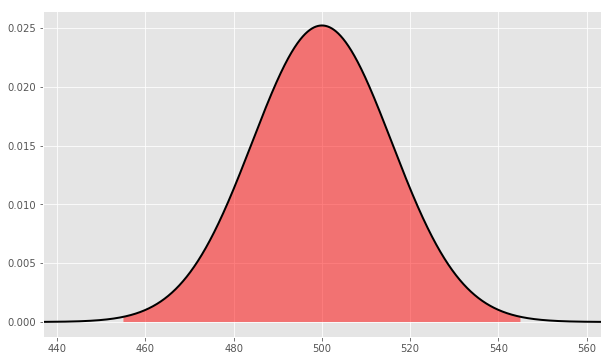

In [12]:
n = 1000
p = 0.5
mu = n*p
sigma = sc.sqrt(n*p*(1-p))
print(norm.cdf(545, loc=mu, scale=sigma) - norm.cdf(455, loc=mu, scale=sigma))

# a plot illustrating the integral 
x = sc.arange(mu-4*sigma,mu+4*sigma,0.001);
plt.plot(x, norm.pdf(x, loc=mu, scale=sigma), linewidth=2, color='k')
x2 = sc.arange(455,545,0.001)
plt.fill_between(x2, y1= norm.pdf(x2,loc=mu, scale=sigma), facecolor='red', alpha=0.5)
plt.xlim([mu-4*sigma,mu+4*sigma])
plt.show()

So again, we see that $99.6\%$ of the time, we would see an event less extreme than 545 heads.  

## Example: "Freshman 15": Fact or Fiction

This example was taken from Devore, pp.314-315. 

"A common belief among the lay public is that body weight increases after entry into college, and the phrase 'freshman 15' has been coined to describe the 15 pounds that students presumably gain over their freshman year."

Let $\mu$ denote the true average weight gain in the first year of college. We take the null hypothesis to be
$$
H_0: \mu \geq 15
$$
so that the alternative hypothesis is that the average weight gain in the first year of college is less than 15 lbs. 

We set a signifnicance level of, say, $\alpha = 1\%$. 

We suppose a random sample of $n$ students is selected, their weights (before and after the first year of college) are measured, and the sample mean $\bar{x}$ and sample standard deviation $s$ are computed. An article in the journal Obesity (2006) cites that for a sample of $n=137$ students, the sample mean weight gain was $\bar{x}=2.42$ lb and with a sample standard deviation of $s=5.72$ lb. 

Assuming $H_0$ to be true, how unlikely is it that we would observe such a small value ($\bar{x}=2.42$)?  We take a normal distribution with mean given by the null value ($\mu = 15$) and variance given by $s^2/n = (5.72)^2/137=0.2388$. The p-value is then computed as $F(2.42)$. 

In [13]:
mu = 15
sigma = sc.sqrt(5.72**2/137)
print('p:', norm.cdf(2.42, loc=mu, scale=sigma))

p: 1.9730635698e-146


The p-value is practically zero, much less than the significance level! The data very strongly contradicts the null hypothesis. We reject the null hypothesis, $H_0$, and conclude that the 'freshman 15' is fiction! 

## Example: Gender in Utah, the z-test

Let's try to determine whether the following statement is true: 
$$
\text{In Utah, there are 50% men and 50% women.}
$$

We model this as a Bernoulli variable with female = 1, male = 0. 

We take as null hypothesis that the proportion of women is $p=0.5$,
$$
H_0: p = 0.5
$$
We set the significance level as $\alpha = 0.05$. 

Now, we need a sample...we can use our class survey with 62 responses. 

In [14]:
class_gender = pd.read_csv('SurveyGenderResponse.csv')
print(class_gender.head())
print(class_gender.describe())

# It is more convenient to map 
# Female -> 1
# Male -> 0
di = {'Female': 1,'Male': 0}
class_gender['Gender'].replace(di,inplace=True)
print(class_gender.head())

   Gender
0  Female
1  Female
2    Male
3    Male
4  Female
       Gender
count      62
unique      2
top      Male
freq       45
   Gender
0       1
1       1
2       0
3       0
4       1


Record the number of female students, size of survey, and percent of female students, and sample standard deviation.

In [15]:
num_f = class_gender['Gender'].sum()
print(num_f)

n = class_gender.size
print(n)

x_bar = class_gender['Gender'].mean()
print(x_bar)

s = class_gender['Gender'].std()
print(s)

17
62
0.27419354838709675
0.44974874000715376


According to our survery, 17 of 62 people are women, so we have $\bar x = 0.27$. 

To proceed, we conduct a **z-test**, which is the same as we did in the previous example, except now we use the normalized z-values, 
$$
z = \frac{\bar{x} - .5}{s/\sqrt{n}}. 
$$
The CLT can be used to show that the $z$ score is distributed according to the "standard" normal distribution with mean $\mu=0$ and standard deviation $\sigma = 1$.

The z-value is generally called a **test statistic**. Every type of hypothesis test has its own test statistic. The z-test is just one example of a hypothesis test, see many more listed [here](https://en.wikipedia.org/wiki/Test_statistic#Common_test_statistics).

In [16]:
z = (x_bar - .5)/(s/sc.sqrt(n)) 
print(z)

-3.9533224217


How unlikely is it to see a z-score less than $z = -3.95$? 
$$
\text{p-value} = \int_{-\infty}^z f(x) dx = F(z)
$$
We can compute this using the function norm.cdf with default arguments 'loc=0' and 'scale=1'.

In [17]:
p_value = norm.cdf(z)
print(p_value)

3.85367345863e-05


Under the assumption of the null hypothesis, we would only see a sample size this extreme $p=0.004\%$ of the time. Since the $p$ value is less than our chosen signficance level, $\alpha = 5\%$, we reject the null hypothesis and conclude that in Utah there are fewer than 50% women. 

**What's wrong with this finding?**

The proceedure we used for the hypothesis test was correct.

However, the students were **not randomly sampled from the population**! If we wanted to address this question, we'd have to account for the fact that the survey was taken at a university in a STEM course, both of which bias the sample (in opposite directions). This is one reason that polling (inference from survey data) is very challenging. 

The 2010 census shows that the percentage of females in Utah is 49.8%.
http://www.census.gov/quickfacts/table/SEX205210/49,4967000

## What to do for smaller sample sizes? Student's t-test

When $n$ is small, the Central Limit Theorem can no longer be used. In this case, if the samples are drawn from an approximately normal distribution, then the correct distribution to use is called the Student's t distribution with $\nu = n-1$ degrees of freedom. The probability density function (pdf) for the student's t distribution is not pretty (Google it!) but it is built into scipy, so we can compare the student's t-test to the normal distribution. 

In [18]:
# there is some trouble with this package for some python versions
# if it doesn't work, don't worry about it
from ipywidgets import interact 

samp_mean = 0
samp_std_dev = 1

x = sc.linspace(samp_mean-4*samp_std_dev,samp_mean+4*samp_std_dev,1000);
def compare_distributions(sample_size):
    pdf1 = norm.pdf(x, loc=samp_mean, scale=samp_std_dev/sc.sqrt(sample_size))
    pdf2 = t.pdf(x,df=sample_size-1,loc=samp_mean, scale=samp_std_dev/sc.sqrt(sample_size))
    plt.plot(x, pdf1, linewidth=2, color='k',label='normal distribution pdf')
    plt.plot(x, pdf2, linewidth=2, color='r',label='t distribution pdf')
    plt.xlim(x.min(),x.max())
    plt.ylim(0,2)
    plt.legend()
    plt.show()
    
interact(compare_distributions,sample_size=(2,20,1))

<function __main__.compare_distributions>

The student's t distribution has "heaveier tails" than the normal distribution. For a sample size greater than $\approx 20$, the normality assumption is generally accepted as reasonable. 

## Types of error in hypothesis testing 

In hypothesis testing, there are two types of errors. A *type I error* is the incorrect rejection of a true null hypothesis (a "false positive"). A *type II error* is incorrectly accepting a false null hypothesis (a "false negative"). Depending on the application, one error can be more consequential than the other. 

![](InferenceErrors.png)
$\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$ 
source: [wikipedia](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors)

The probability of making a type I (false positive error) is the significance level $\alpha$. 

**Examples**

**(1)** In drug testing, we take the null hypothesis (H0): "This drug has no effect on the disease." A type I error detects an effect (the drug cures the disease) that is not present. A type II error fails to detect an effect (the drug cures the disease) that is present. 

**(2)** In a trial, we take the null hypothesis (H0): "This man is innocent." A type I error convicts an innocent person. A type II error lets a guilty person go free. 

## P hacking

Recall that the p-value measures how extreme the observation is and is compared to the significance level. Some comments about the p-value:
1. A p-value is a probability calculated assuming that $H_0$ is true. 
+ The smaller the p-value, the stronger the evidence against $H_0$.
+ A p-value is not the probability that the null hypothesis is true or false. It is the probability that an erroneous conclusion is reached.

Recently the *misuse* of hypothesis testing (p-values) has raised considerable controversy. Basically, if you do enough hypothesis tests, eventually you'll have a Type I (false positive) error. This is a real problem in a world with tons of data in which it is easy to do many, many hypothesis tests automatically. 

You can read more about 'P hacking' here:

- R. Nuzzo, Scientific method: Statistical errors, Nature (2014) [link](https://doi.org/10.1038/506150a)

- J. Cohen, The Earth is Round (p<0.05), American Psychologist (1994) [link](https://doi.org/10.1037/0003-066x.49.12.997)


## A/B testing
A/B testing is a method of comparing two or more versions of an advertisement, webpage, app, etc. We set up an experiment where the variants are shown to users at random and statistical analysis is used to determine which is best. AB testing is the *de facto* test for many business decisions.  

**Example.** A/B testing was extensively used by President Obama during his 2008 and 2012 campaigns to  develop 
* optimized fund-raising strategies,  
* get-out-the-vote programs that would be most beneficial, and 
* target ads to the most susceptible audiences. 

Learn more here:
[Wired story on A/B testing](http://www.wired.com/2012/04/ff_abtesting/)
and 
[Planet Money Episode 669: A or B](https://www.npr.org/sections/money/2015/12/11/459412925/episode-669-a-or-b)

**Example.** Suppose your company is developing an advertisement. The art department develops two internet ads: "Ad A" and "Ad B". Your job is to figure out which is better. 

You decide to do an experiment: You use Google ads to randomly show 1000 internet users Ad A and 1000 internet users Ad B. 

It turns out that 500 Ad A viewers click on the ad while 550 Ad B viewers click on the ad? Obviously Ad B did better, but is the difference "significant" enough to say that Ad B is better? Or perhaps Ad B just got lucky in this test? 

In homework 4, you’ll answer this question. More generally, this is a question about the difference between population proportions. 

## Statistical inference for a difference between population proportions
We consider comparing the population proportions of two different populations. 

We make the following definitions:
- $N_A$ is the number of surveyed people from population $A$  
- $n_A$ is the number of successes from population $A$
- $p_A = n_A/N_A$ is the proportion of successes from population $A$

Similarly, we define 
- $N_B$ is the number of surveyed people from population $B$  
- $n_B$ is the number of successes from population $B$
- $p_B = n_B/N_B$ is the proportion of successes from population $B$

We make the null hypothesis:
$$
H_0\colon \text{$p_A$ and $p_B$ are the same, that is, } p_A - p_B = 0.
$$
That is, the proportion of successes in the two populations is the same. 

We'll take it as a fact (see Devore Ch. 9.4 or Math 3070) that: 
- $n_A/N_A$ is approximately a normal random variable with mean $p_A$ and variance $\sigma_A^2 = p_A(1-p_A)/N_A$ 
- $n_B/N_B$ is approximately a normal random variable with mean $p_B$ and variance $\sigma_B^2 = p_B(1-p_B)/N_B$
- $n_A/N_A - n_B/N_B$ is approximately a normal random variable with mean $\mu = 0$ and variance $\sigma^2 = \sigma_A^2 + \sigma_B^2$. 
- The test statistic called the *two-proportion z-value* 
$$
Z = \frac{p_A - p_B}{\sqrt{\hat{p} \hat{q} \left( \frac{1}{N_A} + \frac{1}{N_B} \right)}}.
$$
is approximately  distributed according to the standard normal distribution when $H_0$ is true. Here $\hat{p} = \frac{N_A}{N_A + N_B}p_A + \frac{N_B}{N_A + N_B}p_B$ and $\hat{q} = 1-\hat{p}$. 

From the data, we estimate the mean, $\mu$, to be  $p_A - p_B$. 

## Example: 1954 Salk polio-vaccine experiment

In 1954, polio was widespread and a new vaccine of unknown efficacy was introduced. To test the efficacy, in a double-blind study, two groups of children were give injections: one contained the vaccine and the other contained a placebo. 

Let $p_A$ and $p_B$ be the proportions of the children, having received the placebo and vaccine injections, respectively, to contract polio. We formulate the null hypothesis that 
$$
H_0\colon p_A - p_B \leq 0,
$$
that is, the vaccine is not effective.
The alternative hypothesis is that 
$$
H_a\colon p_A - p_B >0, 
$$
that is, a vaccinated child is less likely to contract polio than a child receiving the placebo.

We choose a significance level of $\alpha = 0.01$. 

An experiment was conducted with the following results: 
$$
\begin{aligned}
&\text{Placebo:} \quad N_A = 201,229, \quad n_A = 110 \\
&\text{Vaccine:} \quad N_B = 200,745, \quad n_B = 33.
\end{aligned}
$$

In [19]:
nA = 110
NA = 201229
pA = nA/NA
muA = pA
sigmaA = sc.sqrt(pA*(1-pA)/NA)

nB = 33
NB = 200745
pB = nB/NB
muB = pB
sigmaB = sc.sqrt(pB*(1-pB)/NB)

Now we perform the hypothesis test and see what the probability of the outcome is under the assumption of the null hypothesis. 

In [20]:
phat = NA*pA/(NA+NB) + NB*pB/(NA+NB)
qhat = 1-phat

z = (pA - pB)/sc.sqrt(phat*qhat*(1/NA + 1/NB)) 
print(z)

p_value = 1-norm.cdf(z)
print(p_value)

6.42581277008
6.55834275776e-11


The probability that an erroneous conclusion is reached, under the assumption of the null hypothesis, is $6.6\times10^{-11}$, way less than the significance level, $\alpha$. We reject the null hypothesis and declare that the vaccine is more effective than a placebo! 